## Modulation Recognition Example: RML2016.10a Dataset + VT-CNN2 Mod-Rec Network

More information on this classification method can be found at
https://arxiv.org/abs/1602.04105

More information on the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Please cite derivative works

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

To run this example, you will need to download or generate the RML2016.10a dataset (https://radioml.com/datasets/)
You will also need Keras installed with either the Theano or Tensor Flow backend working.

Have fun!

In [43]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
#
# On specolab, we have 4 GPU's. GPU 0, 2, 3 are faster than GPU 1
#
os.environ["THEANO_FLAGS"]  = "floatX=float32,lib.cnmem=1,device=gpu%d"%(0)
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras


In [44]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_SHORT.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [45]:
print "Modulations are", set([qq[0] for qq in Xd.keys()])

Modulations are set(['QPSK', 'QAM64', 'PAM4', 'QAM16', 'BPSK', '8PSK'])


In [46]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

In [47]:
in_shp = list(X_train.shape[1:])
print X_train.shape, in_shp
classes = mods
print "There are", len(classes), "classes"

# in_shp_100 = list(X_train_100.shape[1:])
# print X_train_100.shape, in_shp_100
# classes = mods_100
# print "There are", len(classes), "classes"

(60000, 2, 128) [2, 128]
There are 6 classes


In [48]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
print model.output_shape

(None, 1, 2, 128)


In [49]:
model.add(ZeroPadding2D((0, 5),data_format='channels_first'))
print model.output_shape
#model.add(Convolution2D(256, 1, 3, border_mode='valid', 
#                        activation="relu", name="conv1", init='glorot_uniform'))
model.add(Conv2D(256, (1, 6), kernel_initializer="glorot_uniform",
                 name="conv1", activation="relu", padding="valid",
                 data_format='channels_first'
                 ))
print model.output_shape
model.add(Dropout(dr))
print model.output_shape
model.add(ZeroPadding2D((0, 5),data_format='channels_first'))
print model.output_shape
#model.add(Convolution2D(80, 2, 3, border_mode="valid", 
#                        activation="relu", name="conv2", init='glorot_uniform'))
model.add(Conv2D(80, (2, 6), kernel_initializer="glorot_uniform", 
                 name="conv2", activation="relu", padding="valid",
                data_format='channels_first'))
print model.output_shape
model.add(Dropout(dr))
print model.output_shape
model.add(Flatten())
print model.output_shape

(None, 1, 2, 138)
(None, 256, 2, 133)
(None, 256, 2, 133)
(None, 256, 2, 143)
(None, 80, 1, 138)
(None, 80, 1, 138)
(None, 11040)


In [50]:
#model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
model.add(Dense(256, kernel_initializer="he_normal", 
                activation="relu", name="dense1"))
model.add(Dropout(dr))
#model.add(Dense( len(classes), init='he_normal', name="dense2" ))
model.add(Dense(len(classes), 
                kernel_initializer="he_normal", name="dense2"))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 1, 2, 138)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 133)       1792      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256, 2, 133)       0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 256, 2, 143)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 138)        245840    
_________________________________________________________________
dropout_5 (Dropout)          (None, 80, 1, 138)        0         
__________

In [51]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [62]:
print X_train.shape, Y_train.shape
print X_test.shape, Y_test.shape
print

(60000, 2, 128) (60000, 6)
(60000, 2, 128) (60000, 6)


In [53]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'test.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
#    show_accuracy=False,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                        verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                      verbose=1, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 60000 samples, validate on 60000 samples
Epoch 1/100
8s - loss: 1.7919 - val_loss: 1.7914
Epoch 2/100
8s - loss: 1.7526 - val_loss: 1.6666
Epoch 3/100
8s - loss: 1.6068 - val_loss: 1.4900
Epoch 4/100
8s - loss: 1.4107 - val_loss: 1.2757
Epoch 5/100
8s - loss: 1.2875 - val_loss: 1.2112
Epoch 6/100
8s - loss: 1.2397 - val_loss: 1.1732
Epoch 7/100
8s - loss: 1.2241 - val_loss: 1.1777
Epoch 8/100
8s - loss: 1.2007 - val_loss: 1.1516
Epoch 9/100
8s - loss: 1.1866 - val_loss: 1.1274
Epoch 10/100
9s - loss: 1.1728 - val_loss: 1.1337
Epoch 11/100
8s - loss: 1.1700 - val_loss: 1.1302
Epoch 12/100
9s - loss: 1.1490 - val_loss: 1.0987
Epoch 13/100
8s - loss: 1.1443 - val_loss: 1.1045
Epoch 14/100
9s - loss: 1.1382 - val_loss: 1.0970
Epoch 15/100
9s - loss: 1.1305 - val_loss: 1.0793
Epoch 16/100
9s - loss: 1.1261 - val_loss: 1.0810
Epoch 17/100
9s - loss: 1.1256 - val_loss: 1.0841
Epoch 18/100
9s - loss: 1.1170 - val_loss: 1.0847
Epoch 19/100
9s - loss: 1.1128 - val_loss: 1.0760
Epoch 20/

In [35]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict100S.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

in_shp = list(X_train.shape[1:])
print X_train.shape, in_shp
classes = mods
print "There are", len(classes), "classes"

(60000, 2, 128) [2, 128]
There are 6 classes


In [54]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, 
#                       show_accuracy=True, 
                       verbose=0, batch_size=batch_size)
print score

1.02077214781


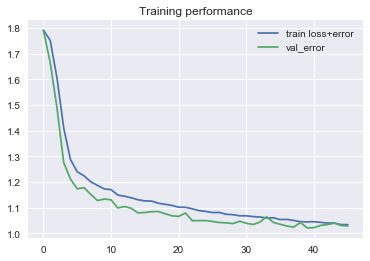

In [55]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [38]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

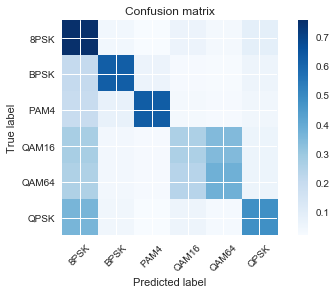

In [60]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.169178082192
Overall Accuracy:  0.165592127587
Overall Accuracy:  0.174757281553
Overall Accuracy:  0.17363877822
Overall Accuracy:  0.165829145729
Overall Accuracy:  0.17328042328
Overall Accuracy:  0.234501347709
Overall Accuracy:  0.314266258086
Overall Accuracy:  0.451247920133
Overall Accuracy:  0.630704041721
Overall Accuracy:  0.7330877428
Overall Accuracy:  0.77095709571
Overall Accuracy:  0.767060367454
Overall Accuracy:  0.775647494114
Overall Accuracy:  0.781198278716
Overall Accuracy:  0.783802100983
Overall Accuracy:  0.777342474698
Overall Accuracy:  0.776069518717
Overall Accuracy:  0.785077583361
Overall Accuracy:  0.780288146693


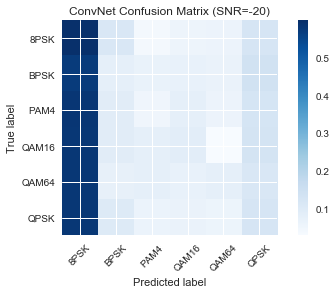

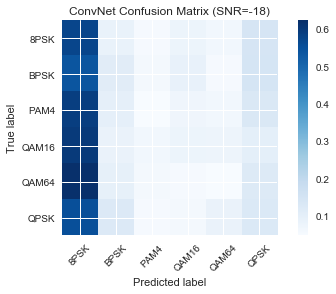

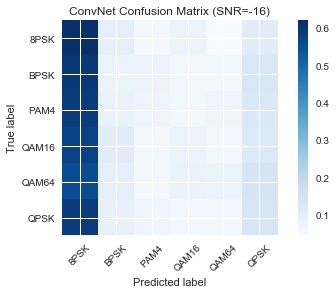

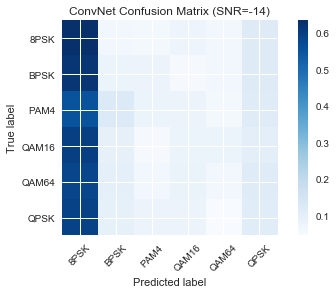

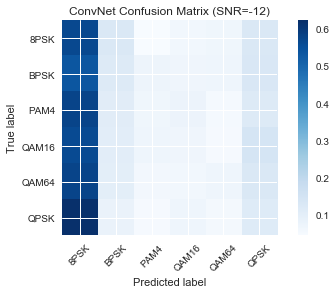

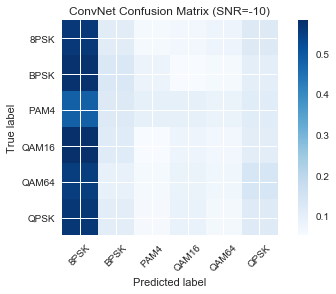

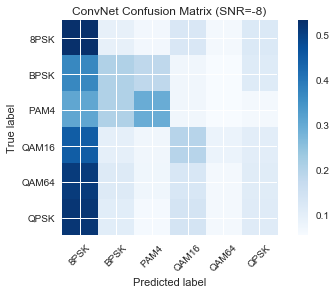

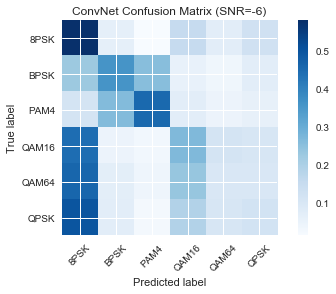

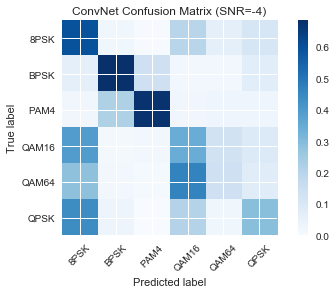

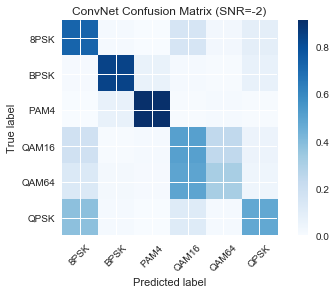

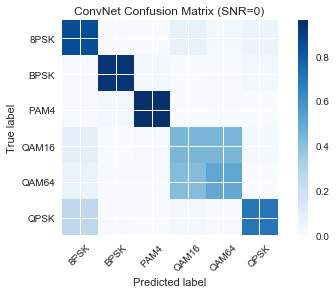

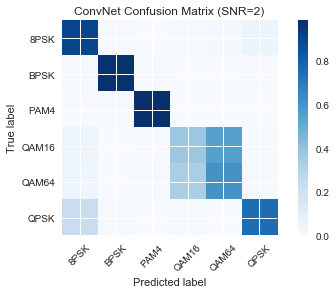

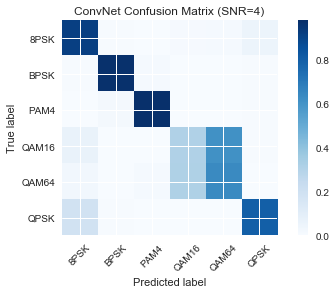

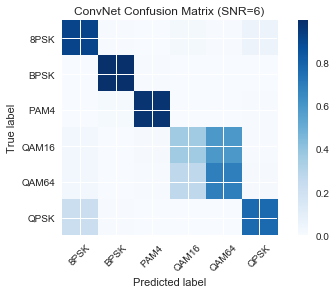

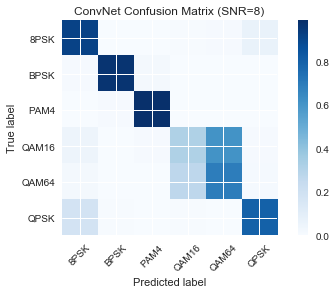

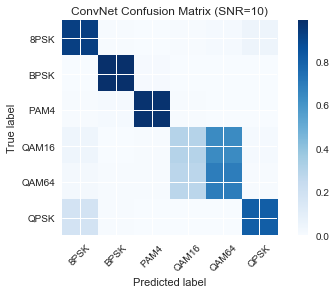

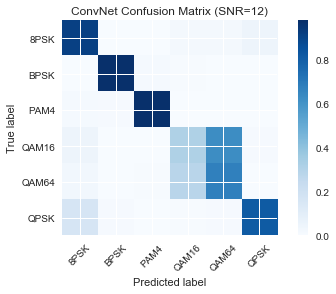

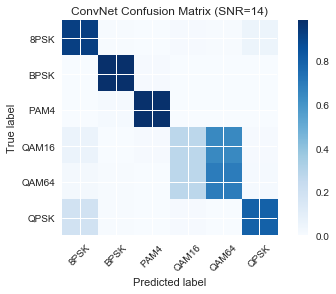

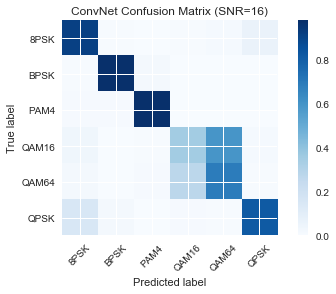

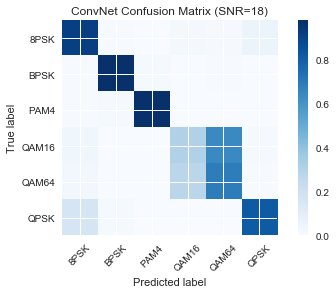

In [57]:
# Plot confusion matrix
acc = {}
for snr in snrs:
    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [58]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.7330877427997321, 16: 0.78507758336084521, 2: 0.77095709570957094, 4: 0.76706036745406825, 6: 0.77564749411368983, 8: 0.78119827871565706, 12: 0.77734247469800843, 10: 0.78380210098271774, -20: 0.16917808219178082, 18: 0.78028814669286184, -18: 0.16559212758737699, -16: 0.17475728155339806, -14: 0.17363877822045154, -12: 0.16582914572864321, 14: 0.77606951871657759, -10: 0.17328042328042328, -8: 0.23450134770889489, -6: 0.31426625808648279, -4: 0.45124792013311149, -2: 0.63070404172099093}


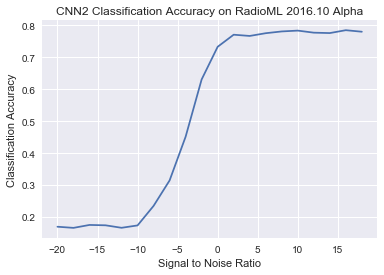

In [59]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")